## PG_modeling_LR_SVM_learning_curves-3years-rolling.ipynb

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve,roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, label_binarize

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/code/functions')
from gis_processing import *
from modeling_functions import *
import pickle

## Data Import
### county grid

In [3]:
project_dir = '/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/'
data_dir = os.path.join(project_dir, "data")

### Target/Feature DF

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))


target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)
target_df

,GRID_ID,month_id,MONTH,COUNTYFP,NAME,GRID_AREA,Y_bin,Y_fire_count,Fire_area,elev_mean,...,tot_prcp_12hrs_10y,tot_prcp_18hrs_10y,Y_bin_new_fire_month,Y_count_new_fires_month,Y_max_new_fire_size_month,YEAR,Y_fire_class_size,geometry,Y_fire_area_prop,month_id_old
0,0,1990_10,10,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.001730,0.002638,0,5,0,1990,0,None,0.0,1990_9
1,0,1990_11,11,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.005466,0.007901,0,3,0,1990,0,None,0.0,1990_10
2,0,1990_12,12,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004499,0.007008,0,2,0,1990,0,None,0.0,1990_11
3,0,1990_2,2,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004638,0.006698,0,0,0,1990,0,None,0.0,1990_1
4,0,1990_3,3,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004855,0.006756,0,2,0,1990,0,None,0.0,1990_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,147,2019_5,5,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000013,0.000022,0,0,0,2019,0,None,0.0,2019_4
47384,147,2019_6,6,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000001,0.000003,0,0,0,2019,0,None,0.0,2019_5
47385,147,2019_7,7,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000112,0.000154,0,0,0,2019,0,None,0.0,2019_6
47386,147,2019_8,8,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000093,0.000185,0,0,0,2019,0,None,0.0,2019_7


#### Feature Lists

In [5]:
RF_entropy_top30_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))
# RF_gini_top20_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_gini_top20_features.pkl'))

In [6]:
non_mod_cols = ['GRID_ID','month_id','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']
        
target_df_working = target_df

In [7]:
non_mod_cols_PCA = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count', 'adj_fire_bcount']
Y_cols_PCA = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Train- test Split

#### select feature and normalize (RF Feature List)

In [8]:
target_model_df=target_df
target_feat = "Y_bin_new_fire_month"
feature_filter = RF_entropy_top30_features

target_model_df[feature_filter] = pd.DataFrame(scale(target_model_df[feature_filter]), columns = feature_filter)
full_time_series_df = target_model_df[["YEAR"] + ["MONTH"] + [target_feat] + feature_filter]

#### Split data into train and test sets (RF Reature List)

In [9]:
train_data_RF = full_time_series_df[(target_model_df['YEAR']>=1990) & (target_model_df['YEAR']<=2016)]
test_data_RF = full_time_series_df[target_model_df['YEAR']>2016]

In [10]:
dataset = train_data_RF
label_name = "Y_bin_new_fire_month"
k = 9
model_LR = LogisticRegression(C=.01, class_weight = 'balanced')


def learning_curve_model_3years_rolling(dataset, label_name, model,k):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}
    year_ranges = []


    for i in range(3,years_len):
        train_fold = dataset[dataset["YEAR"].isin(np.ravel(years_unique[i-3:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = dataset[dataset["YEAR"].isin(np.ravel(years_unique[i]))].drop(["YEAR","MONTH"],axis=1)
#         year_range = str(np.ravel(k_fold_list[i-2:i])[0])+"-"+str(np.ravel(k_fold_list[i-2:i])[-1])
#         year_ranges.append(year_range)


        LR_ts_opt = model.fit(train_fold.drop(label_name, 1),train_fold[label_name])

        LR_ts_y_bin = np.array(validation_fold[label_name])
        LR_ts_preds = LR_ts_opt.predict(validation_fold.drop(label_name,1))
        LR_ts_proba = LR_ts_opt.predict_proba(validation_fold.drop(label_name,1))[:,1]

        AUC_search = roc_auc_score(LR_ts_y_bin, LR_ts_proba)
        recall_search = recall_score(LR_ts_y_bin, LR_ts_preds)
        EV_search = EV_binary(LR_ts_y_bin, LR_ts_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)
        year_range = years_unique[i-3]
        AUC_dict[year_range] = (AUC_search)
        recall_dict[year_range] = (recall_search)
        EV_dict[year_range] = EV_search

    learning_df = pd.DataFrame([AUC_dict,recall_dict,EV_dict])
    learning_df = learning_df.T
    learning_df.columns = ["AUC","Recall","EV"]
    return(learning_df)

In [11]:
def learning_curve_model_3years_rolling_train(dataset, label_name, model,k):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}
    year_ranges = []


    for i in range(3,len(years_unique)):
        train_fold = dataset[dataset["YEAR"].isin(np.ravel(years_unique[i-2:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = dataset[dataset["YEAR"].isin(np.ravel(years_unique[i]))].drop(["YEAR","MONTH"],axis=1)
#         year_range = str(np.ravel(k_fold_list[i-2:i])[0])+"-"+str(np.ravel(k_fold_list[i-2:i])[-1])
#         year_ranges.append(year_range)


        LR_ts_opt = model.fit(train_fold.drop(label_name, 1),train_fold[label_name])

        LR_ts_y_bin = np.array(train_fold[label_name])
        LR_ts_preds = LR_ts_opt.predict(train_fold.drop(label_name,1))
        LR_ts_proba = LR_ts_opt.predict_proba(train_fold.drop(label_name,1))[:,1]

        AUC_search = roc_auc_score(LR_ts_y_bin, LR_ts_proba)
        recall_search = recall_score(LR_ts_y_bin, LR_ts_preds)
        EV_search = EV_binary(LR_ts_y_bin, LR_ts_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)
        year_range = years_unique[i-3]
        AUC_dict[year_range] = (AUC_search)
        recall_dict[year_range] = (recall_search)
        EV_dict[year_range] = EV_search

    learning_df = pd.DataFrame([AUC_dict,recall_dict,EV_dict])
    learning_df = learning_df.T
    learning_df.columns = ["AUC","Recall","EV"]
    return(learning_df)

In [12]:
learning_LR_3yrs_train = learning_curve_model_3years_rolling_train(dataset, label_name, model_LR,k)#learning_curve_model_3years(dataset, label_name, model_LR,k)

In [13]:
learning_LR_3yrs = learning_curve_model_3years_rolling(dataset, label_name, model_LR,k)#learning_curve_model_3years(dataset, label_name, model_LR,k)


range_list = []
for i,j in zip(learning_LR_3yrs.index,learning_LR_3yrs.index + 3):
    range_list.append(str(i) + "-" +str(j))
range_series = pd.Series(range_list)

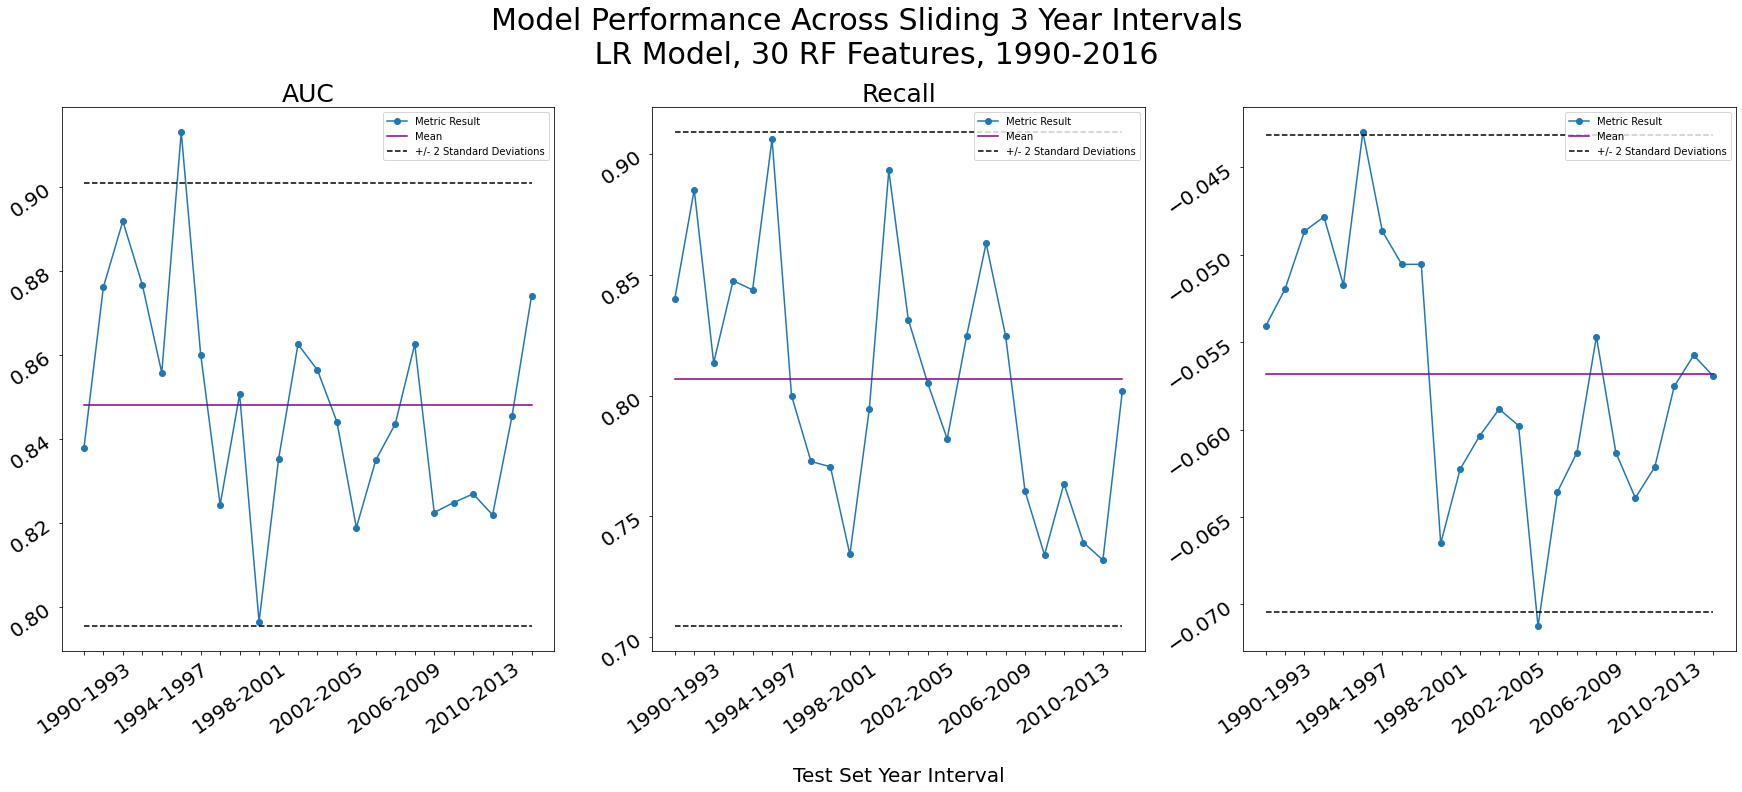

In [69]:
# learning_LR_3yrs = learning_curve_model_3years_rolling(dataset, label_name, model_LR,k)#learning_curve_model_3years(dataset, label_name, model_LR,k)


fig,ax = plt.subplots(1,3, figsize = (30,10))
for i,j in enumerate(learning_LR_3yrs):
    ax[i].plot(learning_LR_3yrs.index,learning_LR_3yrs[j],"o-",label = "Metric Result")
    ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean()]*24,color = "purple",label = "Mean")
    ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean() - 2*learning_LR_3yrs[j].std()]*24, "k--")
    ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean() + 2*learning_LR_3yrs[j].std()]*24, "k--",label = "+/- 2 Standard Deviations")
    
#     ax[i].plot(learning_LR_3yrs.index,learning_LR_3yrs_train[j],"o-",label = "Metric Result")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean()]*24,color = "purple",label = "Mean")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean() - 2*learning_LR_3yrs_train[j].std()]*24, "k--")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean() + 2*learning_LR_3yrs_train[j].std()]*24, "k--",label = "+/- 2 Standard Deviations")

#     ax[i].set_xlabel("Test Set Year Interval",fontsize=20)
    ax[i].set_xticks(learning_LR_3yrs.index)
    ax[i].set_xticklabels(range_series) 
    ax[i].tick_params(labelrotation=35, labelsize =20)
    every_nth = 4
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax[i].legend()
    ax[i].set_title(j,fontsize=25)
fig.suptitle("Model Performance Across Sliding 3 Year Intervals \n LR Model, 30 RF Features, 1990-2016",fontsize=30, y=1.02)
plt.title("Test Set Year Interval",fontsize=20, y=-.25, x=-.70)
plt.savefig('PG_sliding model_perf.png')
plt.show()

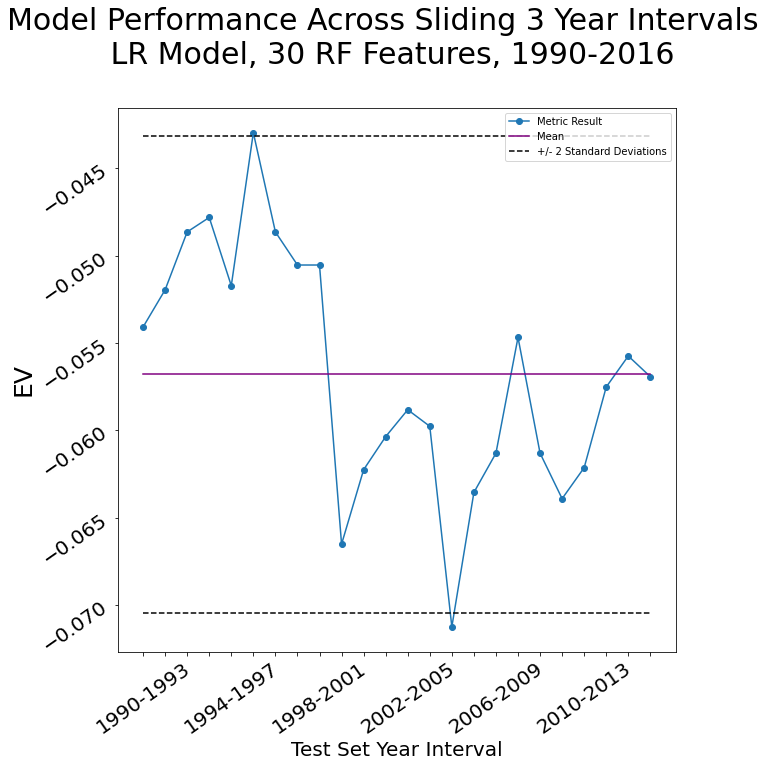

In [64]:
fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.plot(learning_LR_3yrs.index,learning_LR_3yrs[j],"o-",label = "Metric Result")
ax.plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean()]*24,color = "purple",label = "Mean")
ax.plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean() - 2*learning_LR_3yrs[j].std()]*24, "k--")
ax.plot(learning_LR_3yrs.index,[learning_LR_3yrs[j].mean() + 2*learning_LR_3yrs[j].std()]*24, "k--",label = "+/- 2 Standard Deviations")

#     ax[i].plot(learning_LR_3yrs.index,learning_LR_3yrs_train[j],"o-",label = "Metric Result")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean()]*24,color = "purple",label = "Mean")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean() - 2*learning_LR_3yrs_train[j].std()]*24, "k--")
#     ax[i].plot(learning_LR_3yrs.index,[learning_LR_3yrs_train[j].mean() + 2*learning_LR_3yrs_train[j].std()]*24, "k--",label = "+/- 2 Standard Deviations")

ax.set_xlabel("Test Set Year Interval",fontsize=20)
ax.set_xticks(learning_LR_3yrs.index)
ax.set_xticklabels(range_series) 
ax.tick_params(labelrotation=35, labelsize =20)
every_nth = 4
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
ax.legend()
ax.set_ylabel(j,fontsize=25)
fig.suptitle("Model Performance Across Sliding 3 Year Intervals \n LR Model, 30 RF Features, 1990-2016",fontsize=30, y=1.02)
plt.savefig('PG_sliding model_perf_EV.png')
plt.show()

In [39]:
def simp_learning_curve_model(dataset, label_name, model,val_years):
    years_list = []
    years_unique = dataset.YEAR.unique()
    
    AUC_dict_train = {}
    AUC_dict_test = {}
    
    recall_dict_train = {}
    recall_dict_test = {}
    
    EV_dict_train = {}
    EV_dict_test = {}


    for year in years_unique[:-val_years]:
        train_fold = dataset[dataset["YEAR"] <= year].drop(["YEAR","MONTH"],axis=1)
        validation_fold = dataset[dataset["YEAR"] == year+val_years].drop(["YEAR","MONTH"],axis=1)

        LR_ts_opt = model.fit(train_fold.drop(label_name, 1),train_fold[label_name])
        
        LR_ts_y_bin_test = np.array(validation_fold[label_name])
        LR_ts_preds_test = LR_ts_opt.predict(validation_fold.drop(label_name,1))
        LR_ts_proba_test = LR_ts_opt.predict_proba(validation_fold.drop(label_name,1))[:,1]
        
        AUC_search_test = roc_auc_score(LR_ts_y_bin_test, LR_ts_proba_test)
        recall_search_test = recall_score(LR_ts_y_bin_test, LR_ts_preds_test)
        EV_search_test = EV_binary(LR_ts_y_bin_test, LR_ts_preds_test, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)
        
        LR_ts_y_bin_train = np.array(train_fold[label_name])
        LR_ts_preds_train = LR_ts_opt.predict(train_fold.drop(label_name,1))
        LR_ts_proba_train = LR_ts_opt.predict_proba(train_fold.drop(label_name,1))[:,1]

        AUC_search_train = roc_auc_score(LR_ts_y_bin_train, LR_ts_proba_train)
        recall_search_train = recall_score(LR_ts_y_bin_train, LR_ts_preds_train)
        EV_search_train = EV_binary(LR_ts_y_bin_train, LR_ts_preds_train, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)


    #     recall_search = recall_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))
    #     precision_search = precision_score(validation_fold[label_name], LR_ts_kfold.predict(validation_fold.drop(label_name,1)))

        AUC_dict_train[year] = AUC_search_train
        recall_dict_train[year] = recall_search_train
        EV_dict_train[year] = EV_search_train
        
        
        AUC_dict_test[year] = AUC_search_test
        recall_dict_test[year] = recall_search_test
        EV_dict_test[year] = EV_search_test

#         AUC_dict_test[year] =AUC_search_test
    learning_val = pd.DataFrame([AUC_dict_test, AUC_dict_train,recall_dict_test,recall_dict_train,EV_dict_test,EV_dict_train]).T
    learning_val = learning_val.reset_index()
    learning_val.columns = ["Year","AUC Test","AUC Train","Recall Test","Recall Train","EV Test","EV Train"]
    return(learning_val)

In [66]:
val_years = 3
LR_year1_learning_curve = simp_learning_curve_model(dataset, label_name, model_LR,val_years)

rolling_list = []
for i in (LR_year1_learning_curve.Year + 1):
    rolling_list.append(str(1990) + "-" +str(i))
rolling_series = pd.Series(rolling_list)

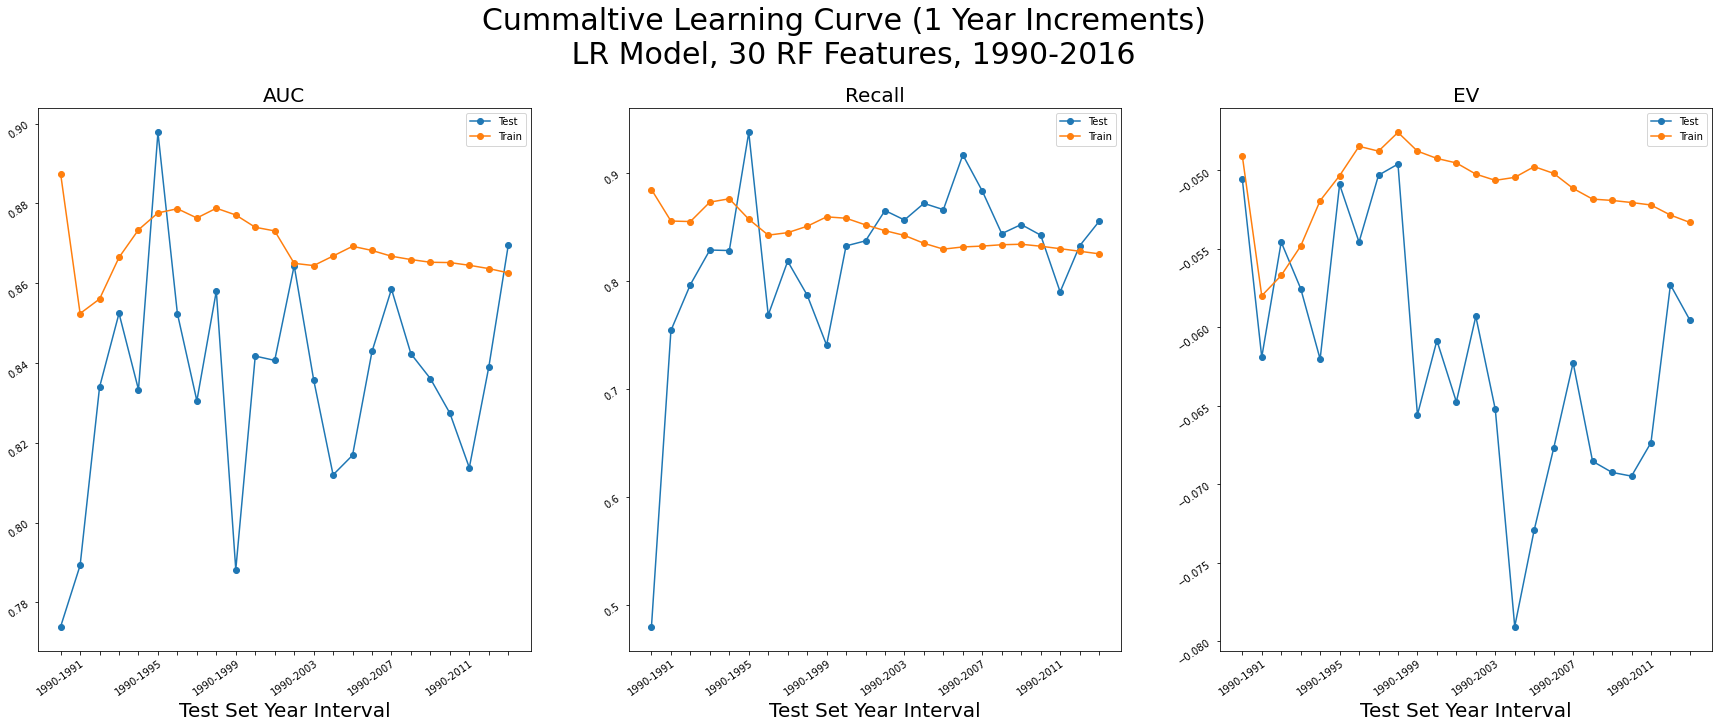

In [71]:
val_years = 3
LR_year1_learning_curve = simp_learning_curve_model(dataset, label_name, model_LR,val_years)

fig,ax = plt.subplots(1,3, figsize = (30,10))

ax[0].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["AUC Test"],"o-",label = "Test")
ax[0].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["AUC Train"],"o-",label = "Train")

ax[1].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["Recall Test"],"o-",label = "Test")
ax[1].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["Recall Train"],"o-",label = "Train")

ax[2].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["EV Test"],"o-",label = "Test")
ax[2].plot(LR_year1_learning_curve.Year,LR_year1_learning_curve["EV Train"],"o-",label = "Train")

for i,j in enumerate(["AUC","Recall","EV"]):
    
    ax[i].set_xlabel("Test Set Year Interval",fontsize=20)
    ax[i].set_xticks(LR_year1_learning_curve.Year)
    ax[i].set_xticklabels(rolling_series) 
    ax[i].tick_params(labelrotation=35)
    every_nth = 4
    for n, label in enumerate(ax[i].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)    
    ax[i].legend()
    ax[i].set_title(j,fontsize=20)

fig.suptitle("Cummaltive Learning Curve (1 Year Increments) \n LR Model, 30 RF Features, 1990-2016",fontsize=30, y=1.02)
plt.savefig('PG_rolling_model_learn.png')
plt.show()